Written by AI22BTECH11023

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1} completed. Last batch loss: {loss.item():.4f}')

# Evaluation loop
model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()

test_acc = correct / len(test_dataset)
print(f'Test accuracy: {test_acc:.4f}')

Epoch 1 completed. Last batch loss: 0.0699
Epoch 2 completed. Last batch loss: 0.0399
Epoch 3 completed. Last batch loss: 0.0441
Epoch 4 completed. Last batch loss: 0.0046
Epoch 5 completed. Last batch loss: 0.0026
Test accuracy: 0.9873


In [2]:
def pgd_attack(model, images, labels, criterion, epsilon=0.3, alpha=0.01, num_iter=40):
    """
    Generate adversarial examples using PGD attack.
    
    Parameters:
        model: the neural network model.
        images: original input images.
        labels: true labels corresponding to the images.
        criterion: loss function.
        epsilon: maximum perturbation allowed.
        alpha: step size for each iteration.
        num_iter: number of attack iterations.
    
    Returns:
        adv_images: adversarially perturbed images.
    """
    # Ensure we work on a detached clone of the original images.
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    ori_images = images.clone().detach()
    
    # Set requires_grad attribute so we can compute gradients on images.
    images.requires_grad = True
    
    for i in range(num_iter):
        outputs = model(images)
        model.zero_grad()
        cost = criterion(outputs, labels)
        cost.backward()
        
        # Collect the element-wise sign of the data gradient
        grad_sign = images.grad.data.sign()
        
        # Create the perturbed image by adjusting each pixel of the input image
        adv_images = images + alpha * grad_sign
        
        # Compute the perturbation by projecting onto the epsilon ball
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
        images.requires_grad = True
    
    return images


In [3]:
# Evaluate model on adversarial examples
model.eval()
correct_adv = 0
total = 0

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    
    # Generate adversarial examples
    adv_data = pgd_attack(model, data, target, criterion, epsilon=0.3, alpha=0.01, num_iter=40)
    
    # Forward pass the adversarial images through the model
    output = model(adv_data)
    pred = output.argmax(dim=1)
    
    correct_adv += pred.eq(target).sum().item()
    total += target.size(0)

adv_accuracy = correct_adv / total
print(f'Adversarial test accuracy: {adv_accuracy:.4f}')


Adversarial test accuracy: 0.9072


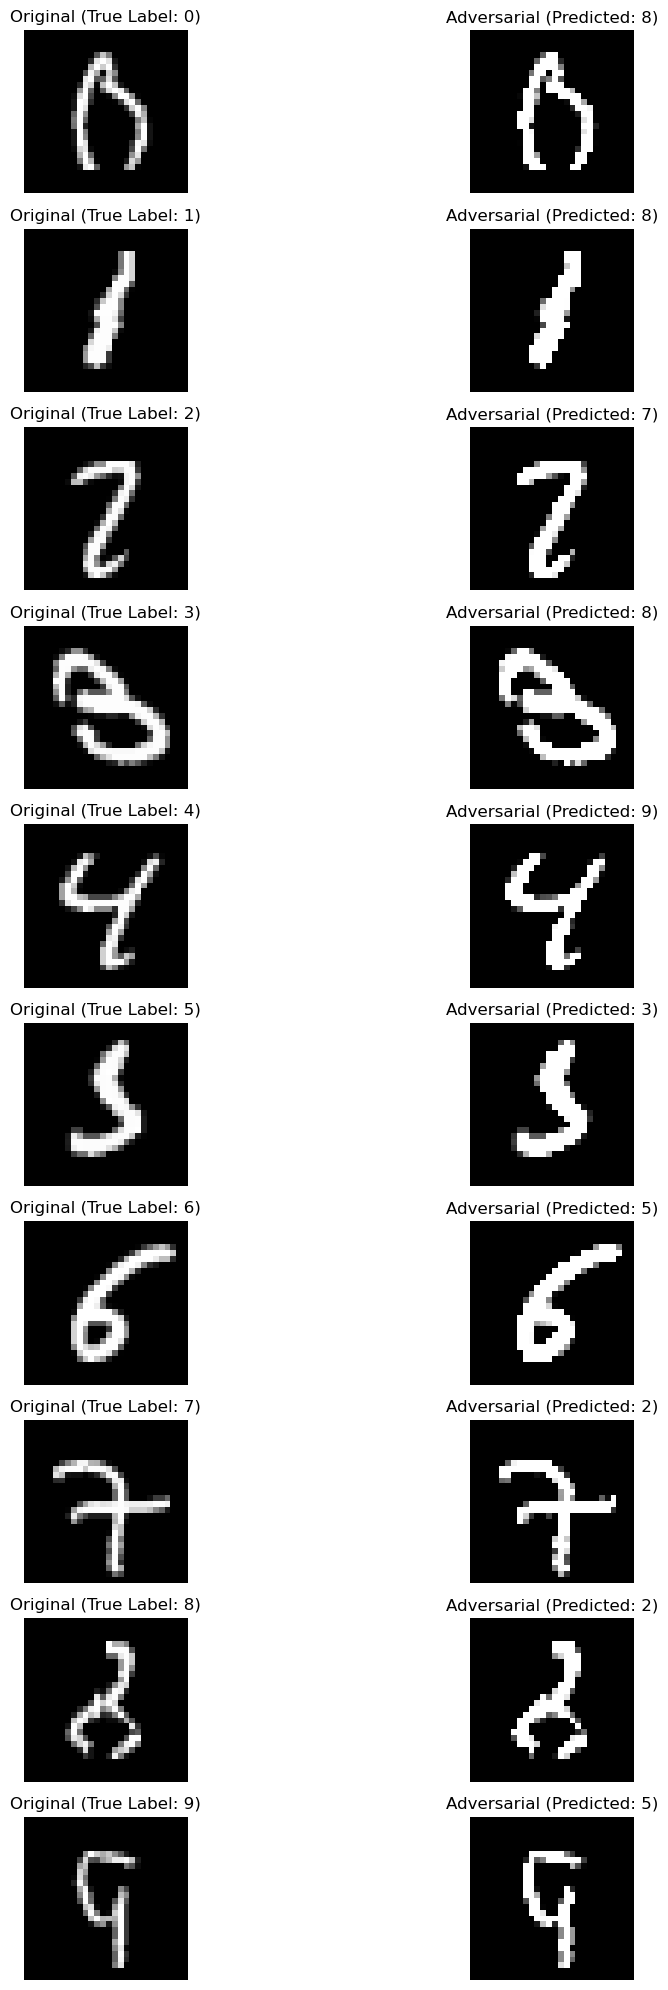

In [5]:
import matplotlib.pyplot as plt

def get_one_adv_input_per_class(model, loader, criterion, epsilon=0.3, alpha=0.01, num_iter=40):
    """
    Collect one misclassified adversarial example per true label (0-9) from the dataset.
    
    Returns:
        A dictionary mapping each true label (0-9) to a dictionary containing:
            - 'original': the original image
            - 'adversarial': the adversarial image
            - 'true_label': the true label
            - 'pred_label': the adversarial prediction (misclassified)
    """
    examples = {}
    model.eval()
    
    # Iterate over the test loader
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        
        # Generate adversarial examples using PGD
        adv_data = pgd_attack(model, data, target, criterion, epsilon, alpha, num_iter)
        output = model(adv_data)
        pred = output.argmax(dim=1)
        
        # Check each sample in the batch
        for i in range(len(target)):
            true_label = target[i].item()
            # We store only misclassified examples and only one per class
            if true_label not in examples and pred[i] != target[i]:
                examples[true_label] = {
                    'original': data[i].detach().cpu(),
                    'adversarial': adv_data[i].detach().cpu(),
                    'true_label': true_label,
                    'pred_label': pred[i].item()
                }
            # Stop if we've collected one for each class (0-9)
            if len(examples) == 10:
                return examples
    return examples

# Get one adversarial input for each class from the test set
adv_examples = get_one_adv_input_per_class(model, test_loader, criterion, epsilon=0.3, alpha=0.01, num_iter=40)

# Plot the examples
plt.figure(figsize=(12, 20))
for idx, label in enumerate(sorted(adv_examples.keys())):
    ex = adv_examples[label]
    
    # Plot original image
    plt.subplot(10, 2, 2*idx + 1)
    plt.imshow(ex['original'].squeeze(), cmap='gray')
    plt.title(f"Original (True Label: {ex['true_label']})")
    plt.axis('off')
    
    # Plot adversarial image
    plt.subplot(10, 2, 2*idx + 2)
    plt.imshow(ex['adversarial'].squeeze(), cmap='gray')
    plt.title(f"Adversarial (Predicted: {ex['pred_label']})")
    plt.axis('off')
    
plt.tight_layout()
plt.show()
